In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [44]:
import time 
class Layer:

    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [45]:
import numpy as np

class Dense(Layer):
    def __init__(self , input_size , output_size) -> None:
        self.weights = np.random.normal(loc=0.0, scale=0.001, size=(output_size, input_size))
        self.bias = np.random.normal(loc=0.0, scale=0.001, size=(output_size,1))
        self.vdw =  np.zeros((output_size, input_size))
        self.vdb =  np.zeros((output_size,1))
        self.sdw =  np.zeros((output_size, input_size))
        self.sdb = np.zeros((output_size,1))
        self.b1 = 0.9
        self.b2 = 0.999
        self.epsilon = 1e-8 
        self.time_fw = 0
        self.time_bw = 0

    def forward(self, input):
        t1 = time.time()
        self.input = input 
        self.time_fw += time.time() - t1 

        return np.dot(self.weights,self.input)+self.bias
    
    def backward(self, output_gradient, learning_rate): 
        t1 = time.time()
        weights_gradient = np.dot(output_gradient,self.input.T)
        self.vdw =self.b1*self.vdw + (1-self.b1)*weights_gradient 
        self.vdb =self.b1*self.vdb + (1-self.b1)*output_gradient 

        self.sdw =self.b2*self.sdw + (1-self.b2)* np.square(weights_gradient)
        self.sdb =self.b2*self.sdb + (1-self.b2)* np.square(output_gradient)


        self.weights -= learning_rate*(self.vdw/np.sqrt(self.sdw + self.epsilon))
        self.bias -= learning_rate*(self.vdb/np.sqrt(self.sdb + self.epsilon))
        self.time_bw += time.time() - t1 
        return np.dot(self.weights.T,output_gradient)

In [46]:
class Activation(Layer):
    def __init__(self, activation, activation_prime) -> None:
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [47]:
def corr_valid(M, K):
    Mshape = M.shape
    Kshape = K.shape
    N = Mshape[0] - Kshape[0] + 1
    M_reshaped = np.lib.stride_tricks.as_strided(M, shape=(N, N, Kshape[0], Kshape[1]), strides=M.strides*2)
    return np.sum(M_reshaped * K, axis=(2, 3))


In [48]:
def mycorrel(M,K):
    # Taking correlation between M (d,H,W,c) and K(d,k,k,c)
    M_dim, M_height , M_width ,M_c = M.shape 
    K_height , K_width  ,k_c,  k_f  = K.shape 
    out_height = M_height - K_height + 1
    out_width = M_width - K_width + 1
    out_f = k_f 
    out_dim = M_dim
    
    output = np.zeros((M_dim , M_height - K_height+1, M_width - K_width+1 , out_f))
    
    for i in range(out_height):
        for j in range(out_width):
            h_start, w_start = i, j
            h_end, w_end = h_start + K_height, w_start + K_width
            intermediate = M[:, h_start:h_end, w_start:w_end, :, np.newaxis] * K[np.newaxis, :, :, :]
            output[:, i, j, :] = np.sum(intermediate,axis=(1, 2, 3))

    return output 


https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5


In [49]:
def Pad(M,ktimes):
    pad_widths = ((ktimes, ktimes), (ktimes, ktimes), (0, 0))

    padded_data = np.pad(M, pad_widths, mode='constant')

    return padded_data

In [50]:
import numpy as np

class Convolutional(Layer):
    def __init__(self , input_shape, kernel_size , depth):
        input_depth, input_height, input_width = input_shape 
        self.depth  = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth , input_height - kernel_size + 1, input_width - kernel_size+1)
        self.kernel_shape = (depth, input_depth, kernel_size,kernel_size)
        self.kernel_size = kernel_size
        mean = 0
        stddev = 0.001
        self.kernels = np.random.normal(mean, stddev, self.kernel_shape)
        self.biases = np.random.normal(mean, stddev, self.output_shape)
        self.vdk =  np.zeros(self.kernel_shape)
        self.vdb =  np.zeros(self.output_shape)
        self.sdk =  np.zeros(self.kernel_shape)
        self.sdb = np.zeros(self.output_shape)
        self.b1 = 0.9
        self.b2 = 0.999
        self.epsilon = 1e-8 
        self.time_fw = 0 
        self.time_bw = 0 
        self.input_height = input_height
        self.input_width = input_width



    def forward(self, input):
        t1 = time.time()
        self.input = input 
        self.output = np.copy(self.biases)
#         for i in range(self.depth):
#             for j in range(self.input_depth):
        intermediate = mycorrel(self.input.reshape(1, self.input_height ,self.input_width,self.input_depth ) , self.kernels.reshape(self.kernel_size, self.kernel_size , self.input_depth,self.depth))
        #intermediate of shape -> 1,d,h,w
        intermediate =  np.squeeze(intermediate).reshape(self.output_shape)
        self.time_fw += time.time() - t1
        return self.output +intermediate
    
    def backward(self, output_gradient, learning_rate):
        t1 = time.time()
        kernel_gradient = np.zeros(self.kernel_shape)
        input_gradient = np.zeros(self.input_shape)
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                kernel_gradient[i,j] =corr_valid(self.input[j] , output_gradient[i])
                
                input_gradient[j] += corr_valid(np.pad(np.rot90(output_gradient[i],2),self.kernel_size-1), self.kernels[i,j] )
        self.vdk =self.b1*self.vdk + (1-self.b1)*kernel_gradient 
        self.vdb =self.b1*self.vdb + (1-self.b1)*output_gradient 

        self.sdk =self.b2*self.sdk + (1-self.b2)* np.square(kernel_gradient)
        self.sdb =self.b2*self.sdb + (1-self.b2)* np.square(output_gradient)


        self.kernels -= learning_rate*(self.vdk/np.sqrt(self.sdk + self.epsilon))
        self.biases -= learning_rate*(self.vdb/np.sqrt(self.sdb + self.epsilon))
        self.time_bw += time.time() - t1 
        return input_gradient
    



In [51]:
class Reshape(Layer):
    def __init__(self,input_shape , output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient,self.input_shape)
    

In [52]:
class MaxPool(Layer):
    def __init__(self,x_dim,size,stride):
        
        self.depth, self.height, self.width = x_dim
        
        self.params = []

        self.size = size
        self.stride = stride
        
        self.final_height = (self.height - size)/stride + 1
        self.final_width = (self.width - size)/stride + 1
        
        
        self.final_height = int(self.final_height)
        self.final_width  = int(self.final_width)
        self.out_dim = (self.depth,self.final_height,self.final_width)

        self.mask = np.zeros(x_dim)
        self.time_fw = 0
        self.time_bw = 0 
        # correct code 
        
    def forward(self,input):
        t1 = time.time()
        self.input = input 
        MK = self.height//self.stride 
        NL = self.width//self.stride 
        self.output = input[:, :MK*self.stride, :NL*self.stride].reshape(self.depth, MK, self.stride, NL, self.stride).max(axis = (2,4))
        maxs = self.output.repeat(2, axis=1).repeat(2, axis=2)
        maxshape = maxs.shape
        maxs = np.pad(maxs, ((0,0), (0 ,self.height - maxshape[1] ) , (0 ,self.width - maxshape[2])),mode='constant')
        self.mask = np.equal(self.input, maxs).astype(int)
        self.time_fw += time.time() - t1 
        return self.output


    def backward(self,output_gradient, learning_rate):
        t1 = time.time() 
        gradient = output_gradient.repeat(2,axis = 1).repeat(2,axis=2)
        gradshape = gradient.shape
        gradient = np.pad(gradient, ((0,0), (0 ,self.height - gradshape[1] ) , (0 ,self.width - gradshape[2])),mode='constant')
        self.time_bw += time.time() - t1 
        return gradient*self.mask 


In [53]:
def multi_cross_entropy(y_true, y_pred):
    eps = 1e-9
    y_pred = np.clip(y_pred, eps,1)
    return -np.mean(y_true*np.log(y_pred))

def multi_cross_entropy_prime(y_true, y_pred):
    eps = 1e-9
    delta = 1e-7  # small constant to avoid numerical instability
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -(y_true / (y_pred + delta))/y_true.shape[0]


In [54]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1/ (1 + np.exp(-x))   

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s*(1-s)
        super().__init__(sigmoid , sigmoid_prime)
         

In [55]:
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x : np.tanh(x)
        tanh_prime = lambda x: 1-np.tanh(x)**2
        super().__init__(tanh,tanh_prime)

In [56]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output 
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output , n)
        return np.dot(tmp*(np.identity(n) - np.transpose(tmp)) , output_gradient)

In [57]:
class Relu(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0  , x) 

        def relu_prime(x):
            return (x>0).astype(x.dtype)
        super().__init__(relu , relu_prime)
         

In [58]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the data batch
def extractimgs(file):

    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32)
    return data,labels 
# Display the first 10 images with labels
def viewdata(data,labels):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(data[i])
        ax.axis('off')
        # Set label as title
        ax.set_title(labels[i])
        if i == 9:
            break
    plt.tight_layout()
    plt.show()


In [59]:
data1,label1 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1')
data2,label2 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2')
data3,label3 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3')
data4,label4 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4')
data5,label5 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5')
data6,label6 = extractimgs('/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch')



In [60]:
# print(data.shape)
# print(len(label))
x_train = np.concatenate((data1,  data2, data3 , data4,data5))


x_val = data6

print(x_train.shape)
print(x_val.shape)


(50000, 3, 32, 32)
(100, 3, 32, 32)


In [61]:
import numpy as np

label = np.concatenate((label1, label2, label3, label4, label5))
labelval = np.array(label6)
num_classes = len(np.unique(label))
y = np.eye(num_classes)[label]
y_v = np.eye(num_classes)[labelval]
y_train = y.reshape(len(y), num_classes, 1)
y_val = y_v.reshape(len(y_v) , num_classes,1)
print(y_train.shape)
print(y_val.shape)



(50000, 10, 1)
(10000, 10, 1)


In [62]:
network = [
    Convolutional((3, 32, 32), 3, 32),
    Relu(),
    MaxPool((32,30,30),2,2),
    Convolutional((32 ,15,15) , 5 , 64 ),
    Relu(),
    MaxPool((64,11,11),2,2),
    Convolutional((64 ,5,5) , 3, 64 ),
    Relu(),
    Reshape((64,3,3), (64 * 3 * 3, 1)),
    Dense(64 * 3 * 3, 64),
    Relu(),
    Dense(64, 10),
    Softmax()
]


In [63]:
import time
total = 0
st = time.time()
epochs = 20
learning_rate = 0.001
batchsize = 32
cursize = 0
curgrad = np.zeros((10,1))
maximgs_train = 5000
maximgs_val = 1000
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_acc = {}  # loss history
y_acc['train'] = []
y_acc['val'] = []
x_epoch = []
for e in range(epochs):
    
    total_train = 0
    total_val = 0
    training_loss = 0 
    validation_loss = 0 
    training_acc = 0 
    validation_acc = 0 
    error = 0 
    error_val = 0
    validation_checks = 0 
    for x , y in zip(x_train, y_train):
        total_train += 1
        cursize+=1
        output = x 
        for layer in network:
            output = layer.forward(output)
        tl = multi_cross_entropy(y , output)
        error += tl
        training_loss += tl
        pred = np.argmax(output)
        correct = np.argmax(y)
        if pred == correct:
            training_acc+=1
        curgrad  += multi_cross_entropy_prime(y , output)
        if cursize % batchsize == 0:
            curgrad /= batchsize 
            for layer in reversed(network):
                curgrad = layer.backward(curgrad , learning_rate)
            curgrad = np.zeros((10,1))
        if cursize == maximgs_train:
            cursize = 0
            break
        if cursize %200 == 199:
            total+=1
            valsize = 0 
            validation_acc = 0
            validation_loss =  0
            for x_v , y_v in zip(x_val, y_val):
                
                if valsize >= maximgs_val:
                    break
                validation_checks+=1
                valsize+=1
                                
                output = x_v 
                for layer in network:
                    output = layer.forward(output)
                vl = multi_cross_entropy(y_v , output)
                error_val += vl
                validation_loss += vl 
                pred = np.argmax(output)
                corrct = np.argmax(y_v)
                if pred == corrct:
                    validation_acc += 1 
            
            y_loss['val'].append(validation_loss / valsize)
            y_loss['train'].append(training_loss/total_train)
            y_acc['val'].append(validation_acc/valsize)
            y_acc['train'].append(training_acc/total_train)
    
    x_epoch.append(total)
    
    error /= maximgs_train
    error_val /= validation_checks
    print(f"{e+1}/{epochs},train error = {error}, val error = {error_val}")

1/20,train error = 0.2302567701611132, val error = 0.23008397141602085
2/20,train error = 0.2299323798960947, val error = 0.2297978249662866
3/20,train error = 0.22953959195575568, val error = 0.22948948917264128
4/20,train error = 0.22913276805184576, val error = 0.22918759660328938
5/20,train error = 0.22873728012361233, val error = 0.22890453620253415
6/20,train error = 0.22836468411810656, val error = 0.2286452459541891
7/20,train error = 0.22801961912093688, val error = 0.22841090352402937
8/20,train error = 0.22770309928233748, val error = 0.22820077186452464
9/20,train error = 0.22741424900654347, val error = 0.22801318872344292
10/20,train error = 0.22715125812644274, val error = 0.22784610817413106
11/20,train error = 0.22691191658641988, val error = 0.2276973969344639
12/20,train error = 0.22669391124808655, val error = 0.2275649908855077
13/20,train error = 0.22649498498877926, val error = 0.2274469714285469
14/20,train error = 0.22631301538931736, val error = 0.227341596123

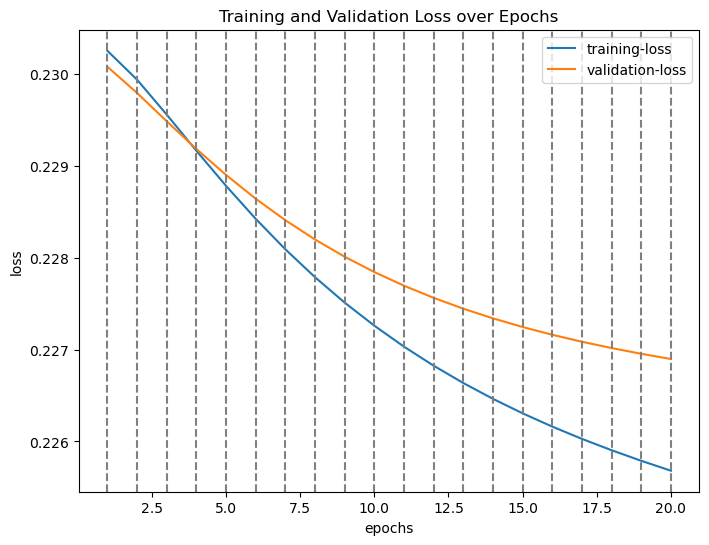

In [64]:
import matplotlib.pyplot as plt

# Define your data
x = [i for i in range(1,total+1)]

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data on the axis
ax.plot(x, y_loss['train'] , label='training-loss')
ax.plot(x, y_loss['val'] , label='validation-loss')

for i in x_epoch:
    ax.axvline(i, color='gray', linestyle='--')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Training and Validation Loss over Epochs')

# Show the graph
plt.show()


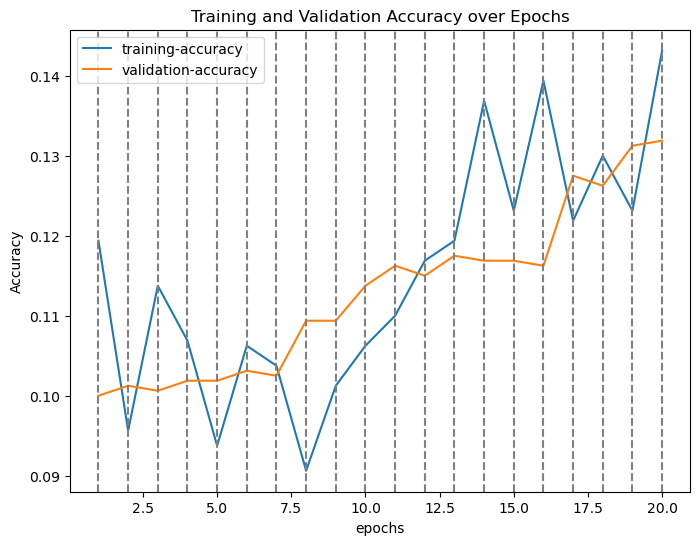

In [ ]:
import matplotlib.pyplot as plt

# Define your data
x = [i for i in range(1,total+1)]


# Set the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data on the axis
ax.plot(x, y_acc['train'] , label='training-accuracy')
ax.plot(x, y_acc['val'] , label='validation-accuracy')

for i in x_epoch:
    ax.axvline(i, color='gray', linestyle='--')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy over Epochs')
# Show the graph
plt.show()


In [ ]:
ac = np.zeros((10,1))
tot = np.zeros((10,1))
s = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for x_v , y_v in zip(x_val, y_val):
                for layer in network:
                    output = layer.forward(output)
                pred = np.argmax(output)
                res = np.argmax(y_v)
                if pred== res :
                    ac[pred] += 1
                tot[res] += 1
tot[tot==0] = 1
for i in range(10):
    print(f"Accuracy for class: {s[i]} is {100*ac[i]/tot[i]} % ")
                    

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 61.6 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 72.6 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %
